# Import Libraries

In [46]:
import tensorflow as tf
from tensorflow.keras import layers

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

import gensim

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset Preprocessing

In [47]:
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin', header= None)

In [48]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [49]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']

df.head(2)

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [50]:
# drop all the olumns except the text column

df.drop(['date', 'id', 'query', 'user_id'], axis=1, inplace=True)

df.head(3)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...


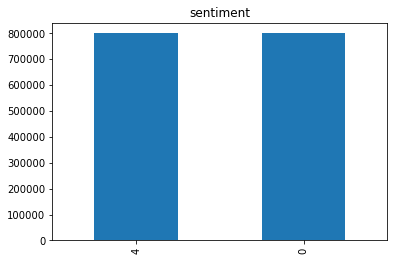

In [51]:
df['sentiment'].value_counts().plot(kind='bar', title='sentiment')

In [52]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
    return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [53]:
df.sentiment.value_counts()

Positive    800000
Negative    800000
Name: sentiment, dtype: int64

# Text Preprocessing

In [54]:
stop_words = stopwords.words('english')
stemmer =  SnowballStemmer('english')

text_cleaning_re =  "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [55]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [56]:
df['text'] = df.text.apply(lambda x : preprocess(x))

In [57]:
df.head()

,sentiment,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset update facebook texting might cry result...
2,Negative,dived many times ball managed save 50 rest go ...
3,Negative,whole body feels itchy like fire
4,Negative,behaving mad see


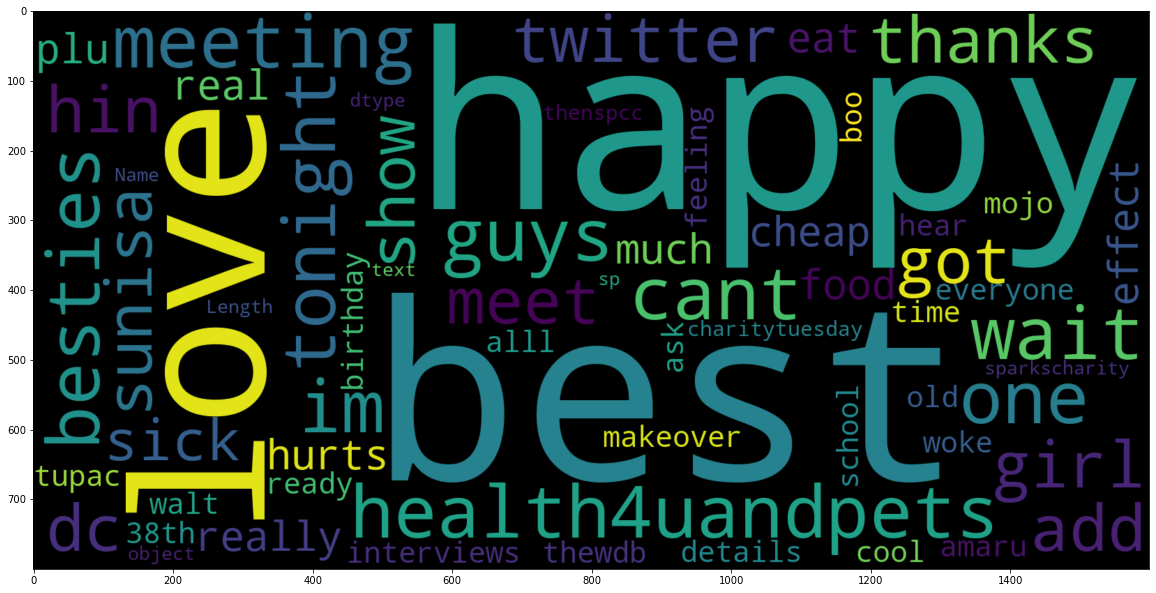

In [58]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words=2000, width = 1600, height = 800).generate(str(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

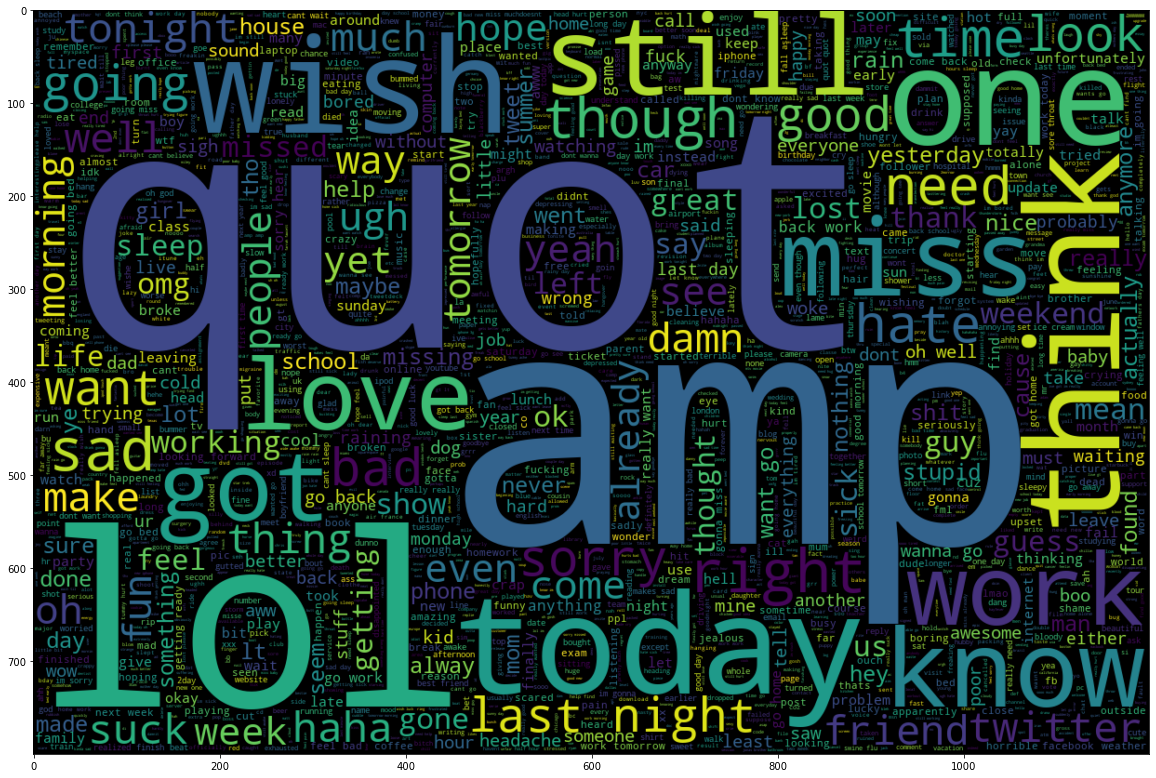

In [59]:
plt.figure(figsize = (20,20))

wc = WordCloud(max_words= 2000, height=800, width=1200).generate(' '.join(df[df['sentiment'] == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

# Train and Test Split

In [60]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [61]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE ,random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size:", len(test_data))

Train Data size: 1280000
Test Data size: 320000


# Word Emdedding

In [70]:
%%time
document = [d.split() for d in train_data['text']]

CPU times: user 3.06 s, sys: 268 ms, total: 3.33 s
Wall time: 3.33 s


In [71]:
word2vec_model = gensim.models.word2vec.Word2Vec(size= 300, window=7, workers=6, min_count=10)

word2vec_model.build_vocab(document)

word = word2vec_model.wv.vocab.keys()

vocab_size = len(word)

print("Vocab size", vocab_size)

Vocab size 30409


In [72]:
word2vec_model.train(document, epochs=32, total_examples=len(document))

(263240524, 295373376)

In [75]:
word2vec_model.most_similar('earth')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('world', 0.44651418924331665),
 ('worlds', 0.3781068027019501),
 ('planet', 0.34740301966667175),
 ('ever', 0.31839123368263245),
 ('everrr', 0.2858520448207855),
 ('angel', 0.2741973400115967),
 ('creatures', 0.2701965272426605),
 ('fears', 0.2691669464111328),
 ('abundant', 0.2678059935569763),
 ('truely', 0.26558423042297363)]

# Tokenize

In [96]:

from tensorflow.keras.preprocessing.text import Tokenizer

tokenize = Tokenizer()

tokenize.fit_on_texts(train_data['text'])
word_index = tokenize.word_index

vocab_size = len(tokenize.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


# Sequence of word

In [97]:
# create sequence of word
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenize.texts_to_sequences(train_data.text), maxlen=MAX_SEQUENCE_LENGTH)

x_test = pad_sequences(tokenize.texts_to_sequences(test_data.text), maxlen=MAX_SEQUENCE_LENGTH)

In [100]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   18,  133,  220, 2319], dtype=int32)

In [101]:
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [102]:
labels = train_data.sentiment.unique().tolist()

# Label Encoding

In [103]:
encoder = LabelEncoder()
# encoder.fit(train_data.sentiment.to_list())

y_train = encoder.fit_transform(train_data.sentiment.to_list())
y_test = encoder.fit_transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [104]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [91]:
# GLOVE_EMB = './glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [92]:
# embeddings_index = {}

# f = open(GLOVE_EMB)
# for line in f:
#     values = line.split()
#     word = value = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' %len(embeddings_index))

In [107]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
        
print(embedding_matrix.shape)

(290575, 300)


# Model Training - LSTM

In [108]:
sequence_input = layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                                   input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)(sequence_input)
x = layers.SpatialDropout1D(0.2)(embedding_layer)

x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512, activation='relu')(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(sequence_input, outputs)

In [109]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',metrics=['accuracy'])

ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [110]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [111]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.4804 - accuracy: 0.7671 - val_loss: 0.4537 - val_accuracy: 0.7841
Epoch 2/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.4582 - accuracy: 0.7811 - val_loss: 0.4455 - val_accuracy: 0.7886
Epoch 3/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.4504 - accuracy: 0.7859 - val_loss: 0.4421 - val_accuracy: 0.7909
Epoch 4/10
1250/1250 [==============================] - 119s 95ms/step - loss: 0.4454 - accuracy: 0.7890 - val_loss: 0.4416 - val_accuracy: 0.7918
Epoch 5/10
1250/1250 [==============================] - 119s 95ms/step - loss: 0.4420 - accuracy: 0.7913 - val_loss: 0.4404 - val_accuracy: 0.7925
Epoch 6/10
1250/1250 [==============================] - 118s 95ms/step - loss: 0.4391 - accuracy: 0.7924 - val_loss: 0.4396 - val_accuracy: 0.7928
Epoch 7/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.4369 - accuracy: 0.7938 - val_loss: 0

In [112]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 105ms/step


In [113]:
from sklearn.metrics import classification_report

print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.80    160542
    Positive       0.79      0.80      0.79    159458

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000

